## 介绍：机器学习项目第三部分
在这个项目中，我们将通过一个完整的机器学习问题来处理真实场景的数据集。利用建筑能源数据，建立一个模型来预测建筑的能源之星的评分，使之成为一个有监督的回归、机器学习任务。

## 机器学习——工作流程
1. 数据清洗与格式转换
2. 探索性数据分析
3. 特征工程与选择
4. 建立基础模型，比较多种模型性能指标
5. 模型超参数调参，针对问题进行优化
6. 在测试集上评估最佳模型
7. 尽可能解释模型结果
8. 得出结论，并提交答案

在这里，我们将专注于最后两个步骤，并尝试窥视我们所构建模型的黑匣子。我们知道它是准确的吗，因为它可以预测能量之星的分数在真实值的9.1分之内，但是它究竟是如何做出预测的呢？我们将研究一些方法来尝试理解GBDT，然后得出结论（data文件夹中有已完成的报告）

### 导入工具包

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

sns.set(font_scale = 2)

# Imputing missing values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree

# LIME for explaining predictions
import lime 
import lime.lime_tabular

In [2]:
# Read in data into dataframes 
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

### 重新创建最终模型

In [3]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy = 'median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [4]:
# Function to calculation mean absolute error
def mae (y_true,y_pred):
    return np.mean(abs(y_true - y_pred))

In [5]:
model = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='lad', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=800,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [6]:
#  Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 9.0839


### 解释模型

机器学习经常被批评为[黑匣子](https://www.technologyreview.com/s/604087/the-dark-secret-at-the-heart-of-ai/)：我们把数据放在一边，它给我们另一边的答案。虽然这些答案通常是非常准确的，但模型并没有告诉我们它是如何做出预测的。这在某种程度上是正确的，但是我们可以尝试并发现模型是如何“思考”的，比如[Locally Interpretable Model-agnostic Explainer (LIME)](https://arxiv.org/pdf/1602.04938.pdf)。这是通过学习一个线性回归来解释模型预测，这是一个易于解释的模型！

我们将探索几种解释模型的方法：
* Feature importances 特征重要性
* Locally Interpretable Model-agnostic Explainer (LIME)  本地可解释模型
* Examining a single decision tree in the ensemble. 查看集成中的单个决策树

### 特征重要性

我们可以解释一组决策树的基本方法之一是通过所谓的特征重要性。这些变量可以解释为对目标最具预测性的变量。虽然特性导入的实际细节相当复杂(这是一个关于这个主题的之外的问题），我们可以使用相对值来比较这些特性，并确定哪些与我们的问题最相关。从一组受过训练的树中提取特征的重要性是相当容易的。我们将把特性的重要性存储在一个数据中，以分析和可视化它们。

In [7]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,Site EUI (kBtu/ft²),0.452163
1,Weather Normalized Site Electricity Intensity ...,0.249107
2,Water Intensity (All Water Sources) (gal/ft²),0.056662
3,Property Id,0.031396
4,Largest Property Use Type_Non-Refrigerated War...,0.025153
5,DOF Gross Floor Area,0.025003
6,log_Water Intensity (All Water Sources) (gal/ft²),0.022335
7,Largest Property Use Type_Multifamily Housing,0.021462
8,Order,0.020169
9,log_Direct GHG Emissions (Metric Tons CO2e),0.019410


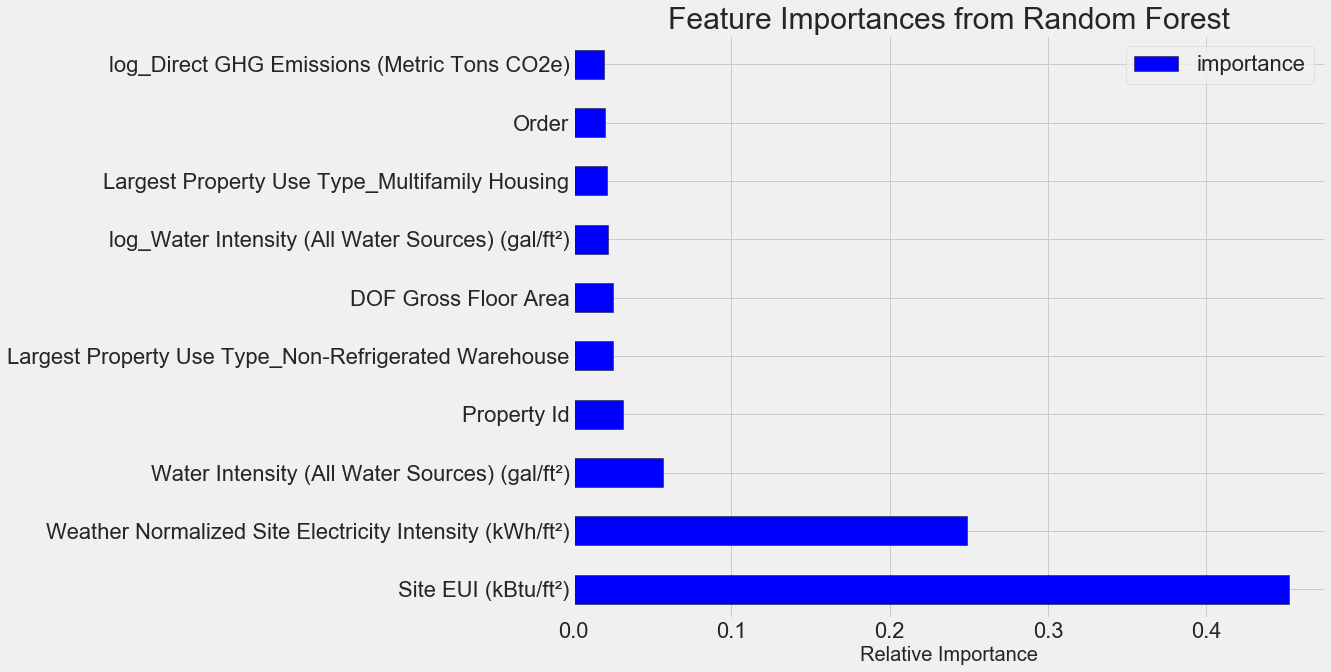

In [8]:
figsize(12, 10)
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

## 基于特征重要性进行选择
拿最重要的部分特征来建模，特征并不是越多越好（一般情况下是越多越好），如果少量特征能达到同样甚至更好的效果，我们理所应当使用少量特征，这里我们选用前10的特征进行尝试。

In [9]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (6622, 10)
Most important testing  features shape:  (2839, 10)


In [10]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE = %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE = 13.4651.
Linear Regression Reduced Results: MAE = 14.5095.


结果表明，试验结果不如原来的

In [18]:
# Create the model with the same hyperparamters
model_gbdt = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

model_gbdt.fit(X, y)
model_full_pred = model_gbdt.predict(X_test)

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Full Results: MAE = %0.4f.' % mae(y_test, model_full_pred))
print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Gradient Boosted Full Results: MAE = 9.0839.
Gradient Boosted Reduced Results: MAE = 9.3735


GBDT出现同样的问题，最终选择使用全部特征。

## Locally Interpretable Model-agnostic Explanations

选择一个预测最好的和预测最差的来分别解释

In [12]:
# Find the residuals
residuals = abs(model_reduced_pred - y_test)
    
# Exact the worst and best prediction
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

In [13]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

**先看一个最差的**

Prediction: 16.3665
Actual Value: 96.0000


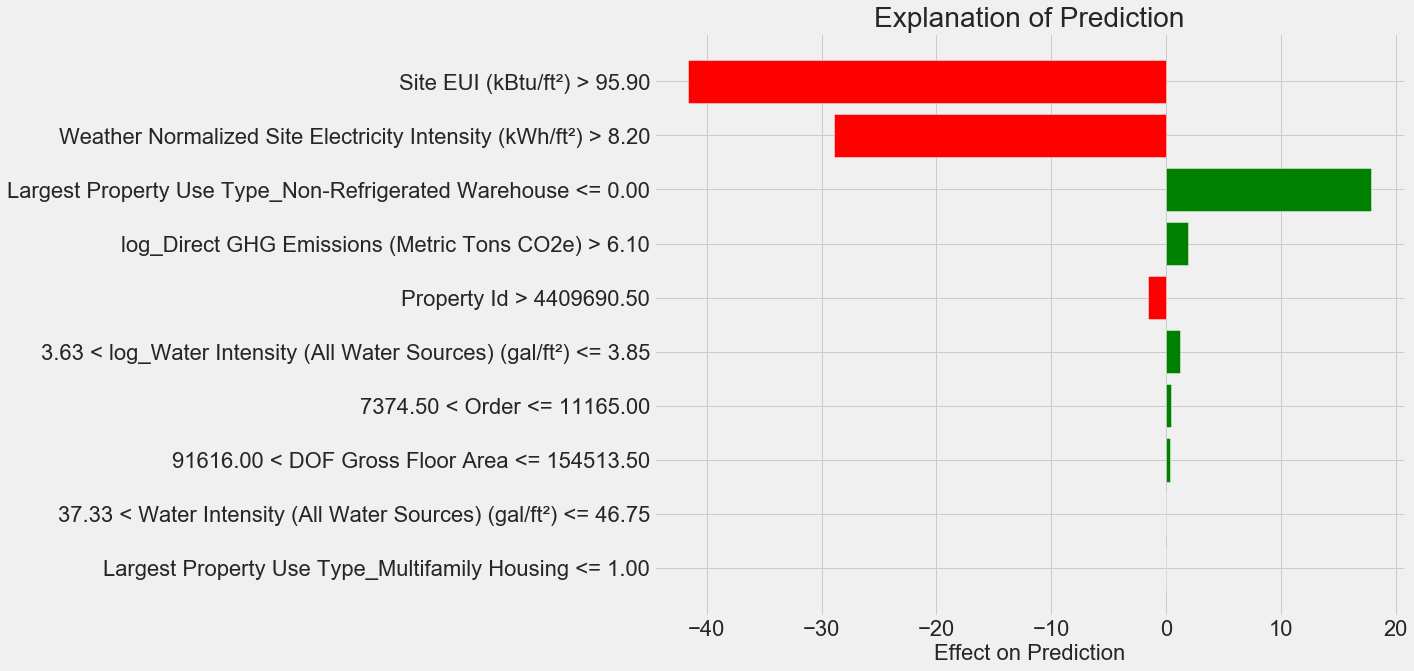

In [19]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = model_reduced.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [20]:
wrong_exp.show_in_notebook(show_predicted_value=False)

预测值16.3665和真实值96.0000差异过大，可能存在问题。

上图表明了Site EUI使得结果值大大下降，由于该值本身大于95.5，正常情况下是能源利用率低了，但是得分却很高，所以有理由认为，该数据点标签值存在问题。

**再看一个最好的**

Prediction: 100.0000
Actual Value: 100.0000


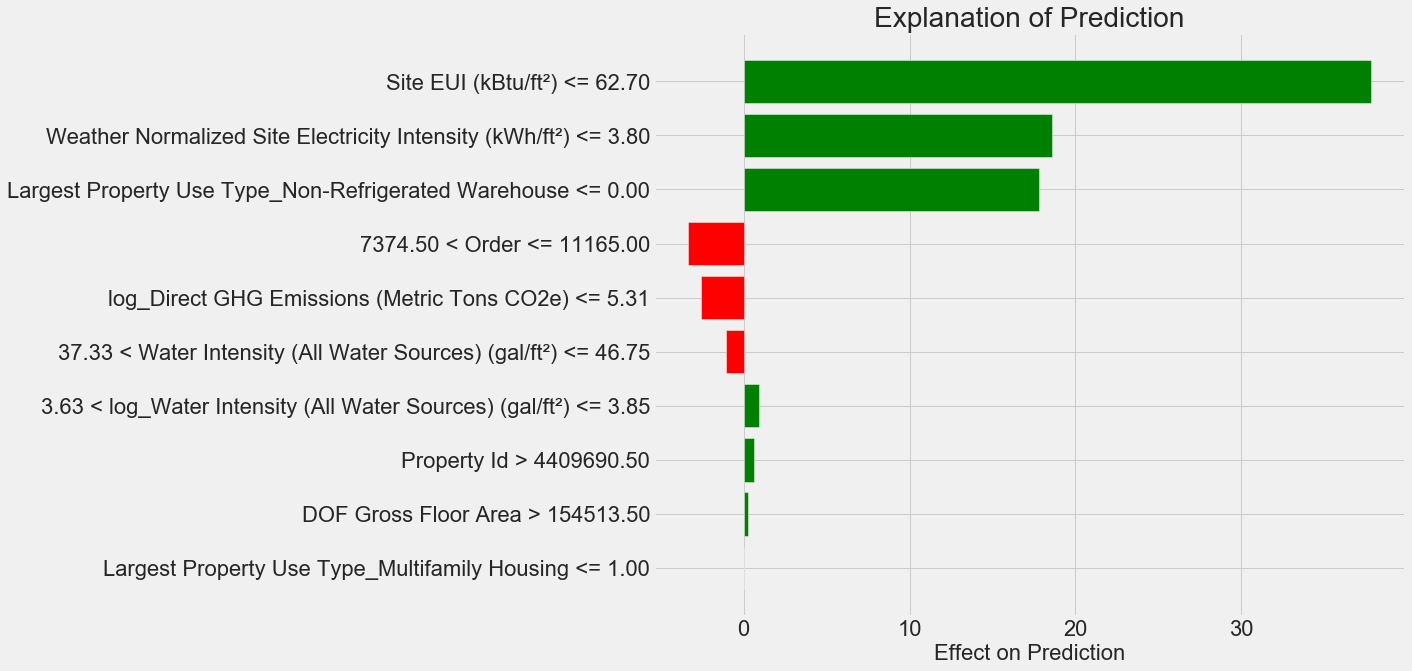

In [21]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [24]:
right_exp.show_in_notebook(show_predicted_value=False)

LIME的图显示了示例中每个特征变量对预测的贡献。例如，由于站点EUI小于62.70，这大大提高了对分数的估计。同样，其它特征也对最终预测作出了积极贡献。

观察这样的分解图可以让我们了解模型是如何做出预测的。对于大量模型的黑盒子情况，这可能是最有价值的，因为我们可以检查错误，也许可以设计出更好的特性，或者调整模型的超参数，以改进下一次的预测。模型偏离最大的示例也可能是需要手动查看的有趣的边缘情况。

该模型严重低估了第一座建筑的能源之星的得分，因为它的Site EUI。因此，我们可能想问，为什么这座建筑拥有如此高的能源之星的得分，尽管它有如此高的Site EUI。像这样一个我们尝试使用机器学习算法来理解问题的过程，似乎比简单地让模型做出预测并完全信任它们要好得多！虽然LIME并不完美，但它代表了向解释机器学习模型的正确方向迈出的一步。

## 单颗树模型观测

关于决策树的集成，最酷的部分之一是我们可以查看任何单独的估计器。虽然我们的最终模型是由800个决策树组成的，而且查看单个决策树并不代表整个模型，但它仍然可以让我们看到决策树是如何工作的。

我们将首先从GBDT中提取一棵树，然后使用`sklearn.tree.export_graphviz`。 它将树保存为.dot文件，然后使用notebook中的命令行将其转换为png。

In [33]:
# Extract a single tree
single_tree = model_reduced.estimators_[105][0]

tree.export_graphviz(single_tree, out_file = 'data/tree.dot',
                     rounded = True, 
                     feature_names = most_important_features,
                     filled = True)

single_tree

DecisionTreeRegressor(criterion='friedman_mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=6,
                      min_samples_split=6, min_weight_fraction_leaf=0.0,
                      presort='auto',
                      random_state=<mtrand.RandomState object at 0x000001E72CA43480>,
                      splitter='best')

In [43]:
# Convert to a png from the command line
# This requires the graphviz visualization library (https://www.graphviz.org/)


# !dot -Tpng data/tree.dot -o data/tree.png

<img src="data/tree.png" width="70%">

In [40]:
tree.export_graphviz(single_tree, out_file = 'data/tree_small.dot',
                     rounded = True, feature_names = most_important_features,
                     filled = True, max_depth = 3)

<img src="data/tree_small.png" width="70%">